# Environment Set Up

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import libraries
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)

# Data Load and Preparation

In [0]:
# read in nba player data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NBA/shooter_and_defender_per_shot_ranked.csv", sep=",")

# Simple normalization of location parameters. Ultimately removed normalization as resulted in negligible to lower performance.
# data[['LOC_X']] = (data[['LOC_X']] +  250)/500
# data[['LOC_Y']] = (data[['LOC_Y']] +  50)/900
# data[['SHOT_DISTANCE']] = data[['SHOT_DISTANCE']]/100

# assume if no player_id for defending player then its a generic player which is 443
data.fillna(value={'defender_embedding_index': 443}, inplace=True)
print(data.shape)
data.head(5)

(27321, 14)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0
1,202704,21500001,437,2575.29,13.97,19.94944,21.56599,200794,0.885241,17.293812,0,1,233,94.0
2,2594,21500001,477,2721.36,11.19,22.62340,11.06127,203484,2.368097,24.070023,1,20,46,306.0
3,2594,21500001,507,2831.96,17.99,22.47487,13.84307,202704,5.118656,22.444323,0,21,46,233.0
4,203076,21500003,504,2421.86,8.87,24.98951,35.88171,202691,2.629288,24.534673,1,16,248,222.0


In [0]:
# filter such that shooter has at least 2 shots for train test split
data_grouped = data.groupby(['player_id']).size().reset_index(name='count')
data_grouped = data_grouped[data_grouped['count'] > 2]

data = data.merge(data_grouped, on=['player_id'], how='inner')

print(data.shape)
data.head(5)

(27297, 15)


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index,defender_embedding_index,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,204


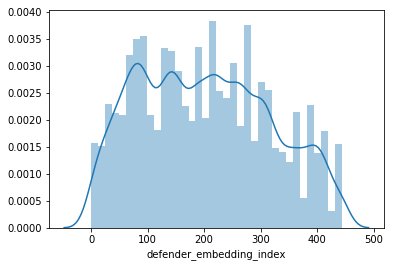

In [0]:
# Distribution of filtered plays across defenders
sns.distplot(data.defender_embedding_index);

# Model Architecture

In [0]:
# Model parameters
terms_embedding_column = tf.feature_column.embedding_column('player_id', dimension=5)
feature_columns = ['shooter_embedding_index', 'x_loc', 'y_loc','recorded_shot_distance', 'closest_distance_from_shooter', 'defender_embedding_index'] #'distance_from_basket',

# + 1 for players without any shot record that are defenders
player_size = 443 + 1
player_size

444

In [0]:
# Define model

# inputs
input1 = keras.layers.Input(shape=(1,))
input2 = keras.layers.Input(shape=(4,))
input3 = keras.layers.Input(shape=(1,))
input4 = keras.layers.Input(shape=(1,))

# offensive player embedding
off_emb = keras.layers.Embedding(input_dim=player_size, output_dim=5,input_length = 1)(input1)
off_emb = keras.layers.Flatten()(off_emb)

# defensive player embedding
def_emb = keras.layers.Embedding(input_dim=player_size, output_dim=5,input_length = 1)(input3)
def_emb = keras.layers.Flatten()(def_emb)

# layer 1
# concatenate offensive 
off_concat = keras.layers.Concatenate(axis=1)([off_emb, input2]) 
# concatenate defensive
def_concat = keras.layers.Concatenate(axis=1)([def_emb, input4]) 

# layer 2
off_relu = keras.layers.Dense(20, activation='relu')(off_concat)
def_relu = keras.layers.Dense(20, activation='relu')(def_concat)

# layer 3
full_concat = keras.layers.Concatenate(axis=1)([off_relu, def_relu])

# fully connected nn
w = keras.layers.Dense(40, activation='relu')(full_concat)
x = keras.layers.Dense(20, activation='relu')(w)
y = keras.layers.Dense(20, activation='relu')(x)
z = keras.layers.Dense(5, activation='relu')(y)
output = keras.layers.Dense(1, activation='sigmoid')(z)

model = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=output)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 5)         2220        input_37[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 5)         2220        input_39[0][0]                   
___________________________________________________________________________________________

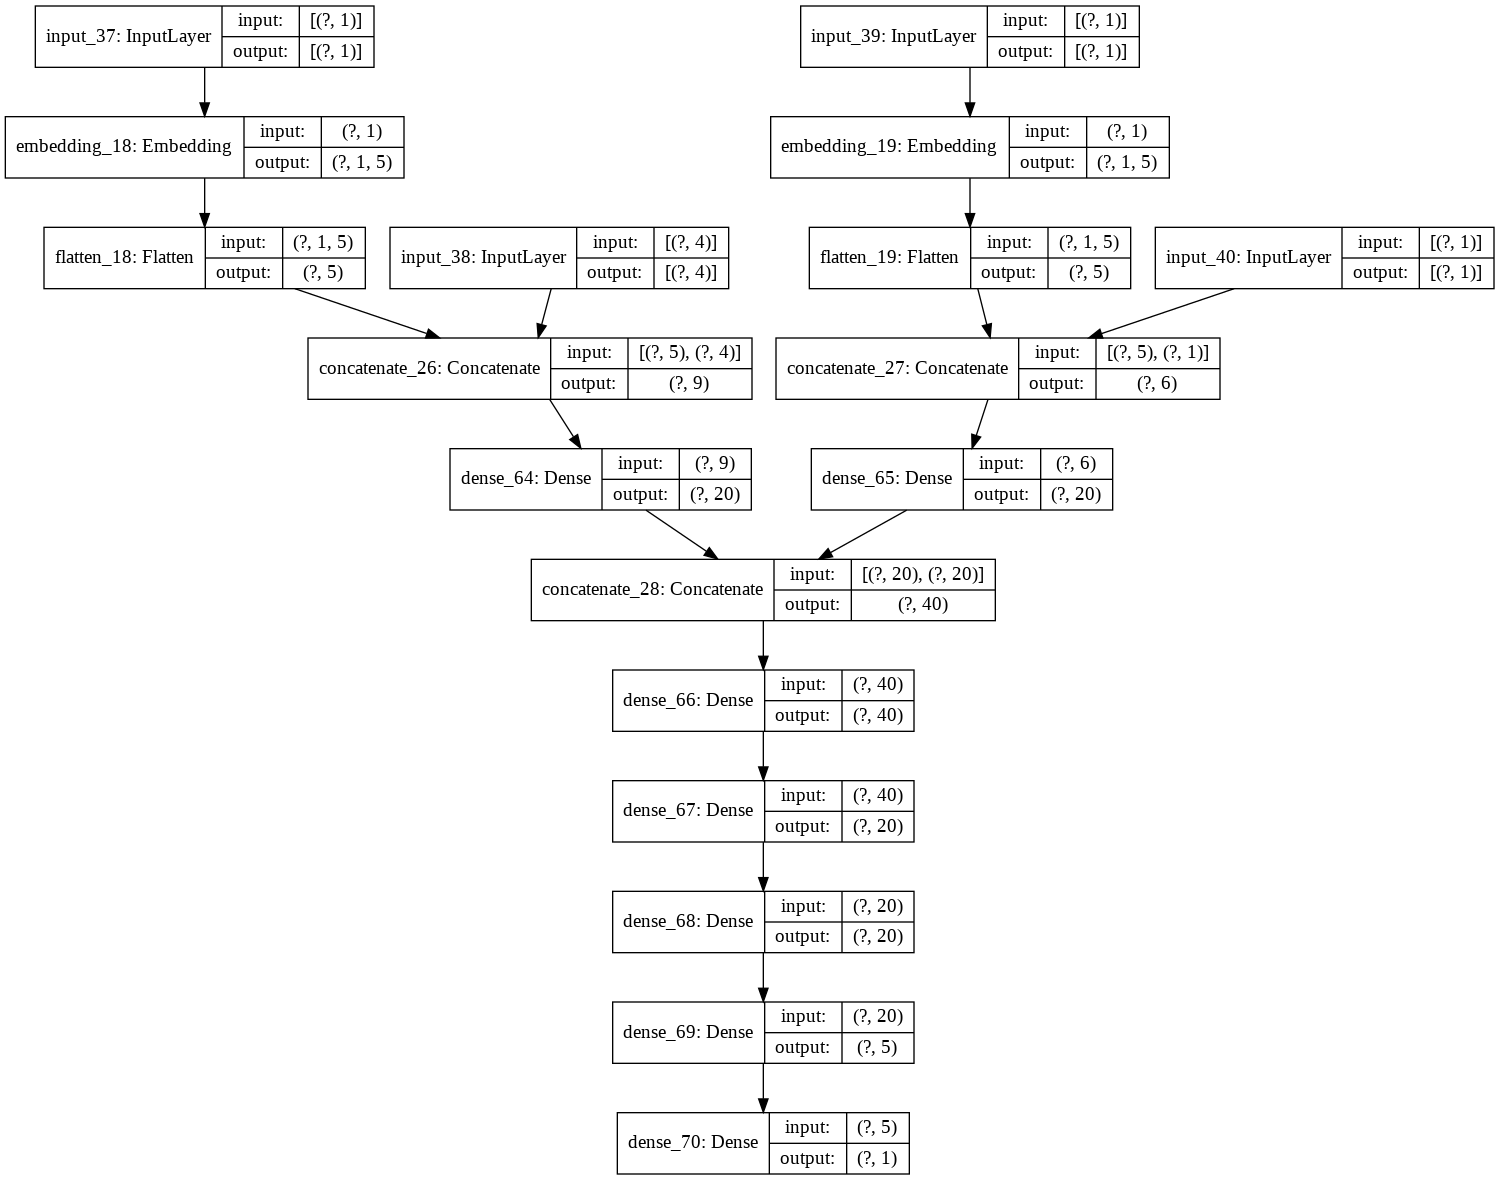

In [0]:
# graphical illustration of model architecutre
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

In [0]:
# auditing via visualization of first few rows of data
data.head()


,player_id,game_id,event_id,game_clock,shot_clock,x_loc,y_loc,player_id_closest_defender,closest_distance_from_shooter,distance_from_basket,shot_made_flag,recorded_shot_distance,shooter_embedding_index_x,defender_embedding_index,shooter_embedding_index_y,count
0,201143,21500001,228,1346.48,10.44,5.90704,38.78493,203083,4.823530,14.088122,1,13,98,255.0,98,204
1,201143,21500389,23,155.78,22.63,34.75976,28.39524,101161,7.724437,31.940727,1,1,98,79.0,98,204
2,201143,21500117,128,684.09,11.85,28.63058,34.59180,201962,11.755243,27.366572,1,24,98,172.0,98,204
3,201143,21500639,9,98.68,14.22,17.88401,27.73281,203943,5.145146,15.132812,0,9,98,364.0,98,204
4,201143,21500117,185,1071.38,12.05,22.85049,28.88055,201583,8.837067,20.226236,1,18,98,139.0,98,204


In [0]:
from sklearn.model_selection import train_test_split

# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data[['shot_made_flag']], stratify=data['player_id'], test_size=0.05, random_state=42)

# prep train data
X_train_shooter = X_train[['shooter_embedding_index']]
X_train_off_rest = X_train[['x_loc', 'y_loc', 'recorded_shot_distance', 'closest_distance_from_shooter']]
X_train_defender = X_train[['defender_embedding_index']]
X_train_defender_rest = X_train[['closest_distance_from_shooter']]

# prep test data
X_test_shooter = X_test[['shooter_embedding_index']]
X_test_off_rest = X_test[['x_loc', 'y_loc', 'recorded_shot_distance', 'closest_distance_from_shooter']]
X_test_defender = X_test[['defender_embedding_index']]
X_test_defender_rest = X_test[['closest_distance_from_shooter']]

In [0]:
# auditing of data shape

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train[:2]

(25932, 6)
(25932, 1)
(1365, 6)
(1365, 1)


,shooter_embedding_index,x_loc,y_loc,recorded_shot_distance,closest_distance_from_shooter,defender_embedding_index
8024,157,20.89377,36.53338,15,3.975135,245.0
17831,105,2.29179,26.56357,1,3.088012,153.0


# Model Training

In [0]:
# model training
history = model.fit([X_train_shooter, X_train_off_rest, X_train_defender, X_train_defender_rest],
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([X_test_shooter, X_test_off_rest, X_test_defender, X_test_defender_rest], y_test),
                    verbose=1)

Train on 25932 samples, validate on 1365 samples
Epoch 1/200
25932/25932 [==============================] - 0s 14us/sample - loss: 0.5181 - acc: 0.7222 - auc_16: 0.8065 - val_loss: 0.9211 - val_acc: 0.5883 - val_auc_16: 0.6061
Epoch 2/200
25932/25932 [==============================] - 0s 15us/sample - loss: 0.5138 - acc: 0.7212 - auc_16: 0.8074 - val_loss: 0.9065 - val_acc: 0.5707 - val_auc_16: 0.6054
Epoch 3/200
25932/25932 [==============================] - 0s 15us/sample - loss: 0.5141 - acc: 0.7196 - auc_16: 0.8065 - val_loss: 0.9225 - val_acc: 0.5868 - val_auc_16: 0.6070
Epoch 4/200
25932/25932 [==============================] - 0s 15us/sample - loss: 0.5088 - acc: 0.7221 - auc_16: 0.8090 - val_loss: 0.9211 - val_acc: 0.5817 - val_auc_16: 0.6020
Epoch 5/200
25932/25932 [==============================] - 0s 15us/sample - loss: 0.5073 - acc: 0.7230 - auc_16: 0.8108 - val_loss: 0.9165 - val_acc: 0.5685 - val_auc_16: 0.5985
Epoch 6/200
25932/25932 [==============================] - 0s

In [0]:
# calculating fpr and tpr for auc curves
from sklearn.metrics import roc_curve
y_pred_train_keras = model.predict([X_train_shooter, X_train_off_rest, X_train_defender, X_train_defender_rest])
fpr_train_keras, tpr_train_keras, thresholds_train_keras = roc_curve(y_train.to_numpy(), y_pred_train_keras)

y_pred_test_keras = model.predict([X_test_shooter, X_test_off_rest, X_test_defender, X_test_defender_rest])
fpr_test_keras, tpr_test_keras, thresholds_test_keras = roc_curve(y_test.to_numpy(), y_pred_test_keras)

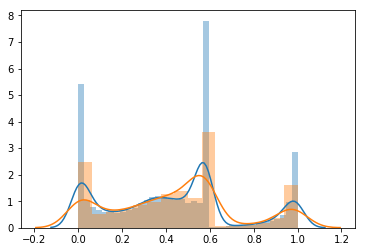

In [0]:
# distribution of predictions
import seaborn as sns
sns.distplot(y_pred_train_keras);
sns.distplot(y_pred_test_keras);

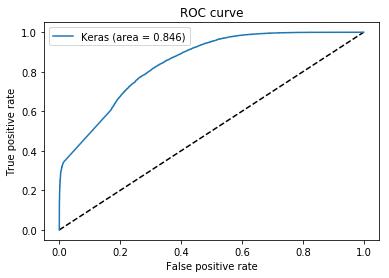

In [0]:
# plot training ROC curve
from sklearn.metrics import auc
auc_keras = auc(fpr_train_keras, tpr_train_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train_keras, tpr_train_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Extract Embedding Weights for Visualization 

In [0]:
# extract offensive player embeddings
offensive_weights = model.layers[2].get_weights()[0]
print(offensive_weights.shape)

# extract defensive player embeddings
defensive_weights = model.layers[3].get_weights()[0]
print(defensive_weights.shape)

(444, 5)
(444, 5)


In [0]:
# filter to only players who have more than 20 shots
filtered_data = data.groupby(['player_id', 'shooter_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_offensive_weights = []
filtered_offensive_players = filtered_data['shooter_embedding_index'].tolist()

for idx, weight in enumerate(offensive_weights):
  if idx in filtered_offensive_players:
    filtered_offensive_weights.append(weight)
    
# filter to only players who have more than 20 defenses
filtered_data = data.groupby(['defender_embedding_index']).size().reset_index(name='count')
filtered_data = filtered_data[filtered_data['count'] > 20]

filtered_defensive_weights = []
filtered_defensive_players = filtered_data['defender_embedding_index'].tolist()

for idx, weight in enumerate(defensive_weights):
  if idx in filtered_defensive_players:
    filtered_defensive_weights.append(weight)

# auditing
print(len(filtered_offensive_weights))
print(len(filtered_defensive_weights))
print(len(filtered_defensive_players))

306
324


In [0]:
# filter player metadata to only players with more than 20 shots
player_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NBA/player_aggregates.csv", sep=",")
shooter_player_data = player_data[player_data['rank'].isin(filtered_offensive_players)]
defender_player_data = player_data[player_data['rank'].isin(filtered_defensive_players)]

In [0]:
import io

# save shooter and defender player embeddings as vecs.tsv
out_vs = io.open('/content/drive/My Drive/Colab Notebooks/NBA/vecs_shooter.tsv', 'w', encoding='utf-8')
for ind, vector in enumerate(filtered_offensive_weights):
  out_vs.write('\t'.join([str(x) for x in vector]) + "\n")
out_vs.close()

out_vd = io.open('/content/drive/My Drive/Colab Notebooks/NBA/vecs_defender.tsv', 'w', encoding='utf-8')
for ind, vector in enumerate(filtered_defensive_weights):
  out_vd.write('\t'.join([str(x) for x in vector]) + "\n")
out_vd.close()


# save player metadata as meta.tsv
shooter_player_data.to_csv('/content/drive/My Drive/Colab Notebooks/NBA/meta_shooter.tsv',sep='\t')
defender_player_data.to_csv('/content/drive/My Drive/Colab Notebooks/NBA/meta_defender.tsv',sep='\t')


In [0]:
# download player embeddings
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/vecs_shooter.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/meta_shooter.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/vecs_defender.tsv')
  files.download('/content/drive/My Drive/Colab Notebooks/NBA/meta_defender.tsv')

In [0]:
# save model in google drive
model.save('/content/drive/My Drive/Colab Notebooks/NBA/offensive_defensive_model_v1.h5') 